# MECO

Feature extraction and data preparation for the MECO dataset

We chose the "joint_data_trimmed.dat" file in the MECO website (https://meco-read.com/).

Interesting paper that describe the dataset, https://link.springer.com/epdf/10.3758/s13428-021-01772-6?sharing_token=As4e3osuA15IaUCKtCvDT5AH0g46feNdnc402WrhzyoEtpF3alySPm1lAWocS1ewk9OZlpPc3CqibACC23iBC_nacc6BD4_GPYLuUZJAvfWHoa8e0hjmhhFn9fLIgIRd3VzSfjlcpQ3gS4EiUY2YpRXjDSh3hB5Zx5kZpkk4yIQ=.

## Import Libs and Data

In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances_argmin_min

In [2]:
df = pd.read_csv("augmenting_nlms_meco_data/joint_data_trimmed.csv", index_col=0)

We have chose to use the following features for each sample:

- **Skipping**: a binary index of whether the word was fixated at least once during the entire reading of the text [and not only during the first pass].
- **First Fixation**: the duration of the first fixation landing on the word.
- **Gaze Duration**: the summed duration of fixations on the word in the first pass, i.e., before the gaze leaves it for the first time.
- **Total Fixation Duration**: the summed duration of all fixations on the word.
- **First-run Number of Fixation**: the number of fixations on a word during the first pass.
- **Total Number of Fixations**: number of fixations on a word overall.
- **Regression**: a binary index of whether the gaze returned to the word after inspecting further textual material.
- **Rereading**: a binary index of whether the word elicited fixations after the first pass.


In [3]:
# following a paper cited on the MECO website, i will use a subset of the gaze features
gaze_features = ["skip", "firstfix.dur", "firstrun.dur", "dur", "firstrun.nfix", "nfix", "refix", "reread"]
other_features = ["trialid", "sentnum", "ianum", "ia", "lang", "uniform_id"]
df = df[other_features + gaze_features]

In [4]:
df.head()

,trialid,sentnum,ianum,ia,lang,uniform_id,skip,firstfix.dur,firstrun.dur,dur,firstrun.nfix,nfix,refix,reread
1,1.0,1.0,1.0,Janus,du,du_1,0.0,154.0,154.0,400.0,1.0,2.0,0.0,1.0
2,1.0,1.0,2.0,is,du,du_1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.0,1.0,3.0,in,du,du_1,0.0,551.0,551.0,551.0,1.0,1.0,0.0,0.0
4,1.0,1.0,4.0,de,du,du_1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1.0,1.0,5.0,oude,du,du_1,0.0,189.0,189.0,439.0,1.0,2.0,0.0,1.0


## Data Understanding

We can notice that there are some Null elements, for the gaze_features except skip, those Null elements are in the rows with skip == 1, representing the fact that cannot be captured.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 855123 entries, 1 to 855123
Data columns (total 14 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   trialid        855122 non-null  float64
 1   sentnum        855122 non-null  float64
 2   ianum          855122 non-null  float64
 3   ia             854741 non-null  object 
 4   lang           855122 non-null  object 
 5   uniform_id     855123 non-null  object 
 6   skip           855122 non-null  float64
 7   firstfix.dur   639530 non-null  float64
 8   firstrun.dur   639530 non-null  float64
 9   dur            639530 non-null  float64
 10  firstrun.nfix  639530 non-null  float64
 11  nfix           639530 non-null  float64
 12  refix          639454 non-null  float64
 13  reread         639530 non-null  float64
dtypes: float64(11), object(3)
memory usage: 97.9+ MB


In [6]:
df.describe()

,trialid,sentnum,ianum,skip,firstfix.dur,firstrun.dur,dur,firstrun.nfix,nfix,refix,reread
count,855122.000000,855122.000000,855122.000000,855122.000000,639530.000000,639530.000000,639530.000000,639530.000000,639530.000000,639454.000000,639530.000000
mean,6.319812,5.100584,84.710652,0.252118,214.771812,274.000635,396.190598,1.291295,1.870305,0.270565,0.315846
std,3.440210,2.697842,51.443266,0.434229,94.834265,181.464901,332.095123,0.666067,1.378493,0.444252,0.464852
min,1.000000,1.000000,1.000000,0.000000,2.000000,2.000000,2.000000,1.000000,1.000000,0.000000,0.000000
25%,3.000000,3.000000,41.000000,0.000000,156.000000,171.000000,199.000000,1.000000,1.000000,0.000000,0.000000
50%,6.000000,5.000000,82.000000,0.000000,200.000000,229.000000,297.000000,1.000000,1.000000,0.000000,0.000000
75%,9.000000,7.000000,124.000000,1.000000,255.000000,324.000000,478.000000,1.000000,2.000000,1.000000,1.000000
max,12.000000,16.000000,243.000000,1.000000,12688.000000,12688.000000,15579.000000,44.000000,50.000000,1.000000,1.000000


In [7]:
df.lang.unique()

array(['du', 'ee', 'fi', 'ge', 'gr', 'he', 'it', 'ko', 'en', 'no', nan,
       'ru', 'sp', 'tr'], dtype=object)

Get a subset of languages, 

- **English**
- **Italian**

In [8]:
df = df[df.lang.isin(["en", "it"])]

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 171595 entries, 397572 to 604808
Data columns (total 14 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   trialid        171595 non-null  float64
 1   sentnum        171595 non-null  float64
 2   ianum          171595 non-null  float64
 3   ia             171525 non-null  object 
 4   lang           171595 non-null  object 
 5   uniform_id     171595 non-null  object 
 6   skip           171595 non-null  float64
 7   firstfix.dur   122875 non-null  float64
 8   firstrun.dur   122875 non-null  float64
 9   dur            122875 non-null  float64
 10  firstrun.nfix  122875 non-null  float64
 11  nfix           122875 non-null  float64
 12  refix          122847 non-null  float64
 13  reread         122875 non-null  float64
dtypes: float64(11), object(3)
memory usage: 19.6+ MB


In [10]:
df.head()

,trialid,sentnum,ianum,ia,lang,uniform_id,skip,firstfix.dur,firstrun.dur,dur,firstrun.nfix,nfix,refix,reread
397572,1.0,2.0,25.0,come,it,it_3,0.0,555.0,555.0,555.0,1.0,1.0,0.0,0.0
397573,1.0,2.0,26.0,avente,it,it_3,0.0,282.0,282.0,282.0,1.0,1.0,0.0,0.0
397574,1.0,2.0,27.0,due,it,it_3,0.0,281.0,281.0,281.0,1.0,1.0,0.0,0.0
397575,1.0,2.0,28.0,"facce,",it,it_3,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
397576,1.0,2.0,29.0,poiché,it,it_3,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Notice that in the samples' gaze_features with skip == 0 there aren't Null elements.

In [11]:
df[df.skip==0].info()

<class 'pandas.core.frame.DataFrame'>
Index: 122875 entries, 397572 to 604808
Data columns (total 14 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   trialid        122875 non-null  float64
 1   sentnum        122875 non-null  float64
 2   ianum          122875 non-null  float64
 3   ia             122868 non-null  object 
 4   lang           122875 non-null  object 
 5   uniform_id     122875 non-null  object 
 6   skip           122875 non-null  float64
 7   firstfix.dur   122875 non-null  float64
 8   firstrun.dur   122875 non-null  float64
 9   dur            122875 non-null  float64
 10  firstrun.nfix  122875 non-null  float64
 11  nfix           122875 non-null  float64
 12  refix          122847 non-null  float64
 13  reread         122875 non-null  float64
dtypes: float64(11), object(3)
memory usage: 14.1+ MB


In [12]:
df[df.skip==1].info()

<class 'pandas.core.frame.DataFrame'>
Index: 48720 entries, 397575 to 604806
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   trialid        48720 non-null  float64
 1   sentnum        48720 non-null  float64
 2   ianum          48720 non-null  float64
 3   ia             48657 non-null  object 
 4   lang           48720 non-null  object 
 5   uniform_id     48720 non-null  object 
 6   skip           48720 non-null  float64
 7   firstfix.dur   0 non-null      float64
 8   firstrun.dur   0 non-null      float64
 9   dur            0 non-null      float64
 10  firstrun.nfix  0 non-null      float64
 11  nfix           0 non-null      float64
 12  refix          0 non-null      float64
 13  reread         0 non-null      float64
dtypes: float64(11), object(3)
memory usage: 5.6+ MB


We noticed that, for skip=1 and skip=0, there are some "ia" elements NULL, We can see that those rows have a lot of NULL elements over the GAZE features, so we will drop them.

~~We will drop them because, even more, "ia" feature represent the text of the word so without the text the element cannot be processed by our machine learning model.~~

We will use a padding token to represent the null ia elements to have more 

In [13]:
print("Probabilities of Null elements by columns, for the Null ia")
df[df.ia.isna()].isna().sum()/df[df.ia.isna()].shape[0]

Probabilities of Null elements by columns, for the Null ia


trialid          0.0
sentnum          0.0
ianum            0.0
ia               1.0
lang             0.0
uniform_id       0.0
skip             0.0
firstfix.dur     0.9
firstrun.dur     0.9
dur              0.9
firstrun.nfix    0.9
nfix             0.9
refix            0.9
reread           0.9
dtype: float64

In [14]:
print("Number of Null elements by columns, for the Null ia")
df[df.ia.isna()].isna().sum()

Number of Null elements by columns, for the Null ia


trialid           0
sentnum           0
ianum             0
ia               70
lang              0
uniform_id        0
skip              0
firstfix.dur     63
firstrun.dur     63
dur              63
firstrun.nfix    63
nfix             63
refix            63
reread           63
dtype: int64

In [15]:
df[df.ia.isna()]

,trialid,sentnum,ianum,ia,lang,uniform_id,skip,firstfix.dur,firstrun.dur,dur,firstrun.nfix,nfix,refix,reread
399129,9.0,6.0,147.0,NaN,it,it_3,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
400261,9.0,6.0,147.0,NaN,it,it_4,0.0,97.0,97.0,97.0,1.0,1.0,0.0,0.0
401436,9.0,6.0,147.0,NaN,it,it_5,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
404528,9.0,6.0,147.0,NaN,it,it_7,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
406588,9.0,6.0,147.0,NaN,it,it_8,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
594782,3.0,8.0,149.0,NaN,en,en_94,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
596890,3.0,8.0,149.0,NaN,en,en_95,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
598998,3.0,8.0,149.0,NaN,en,en_97,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
601106,3.0,8.0,149.0,NaN,en,en_98,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
ia_nan_els = df.ia.isna()
df.ia = df.ia.fillna("[PAD]")
df[ia_nan_els].

SyntaxError: invalid syntax (2023170302.py, line 3)

Fill gaze features of the skipped words with 0.

In [15]:
df = df.fillna(0)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 171525 entries, 397572 to 604808
Data columns (total 14 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   trialid        171525 non-null  float64
 1   sentnum        171525 non-null  float64
 2   ianum          171525 non-null  float64
 3   ia             171525 non-null  object 
 4   lang           171525 non-null  object 
 5   uniform_id     171525 non-null  object 
 6   skip           171525 non-null  float64
 7   firstfix.dur   171525 non-null  float64
 8   firstrun.dur   171525 non-null  float64
 9   dur            171525 non-null  float64
 10  firstrun.nfix  171525 non-null  float64
 11  nfix           171525 non-null  float64
 12  refix          171525 non-null  float64
 13  reread         171525 non-null  float64
dtypes: float64(11), object(3)
memory usage: 19.6+ MB


In [17]:
# 
df[["skip", "firstrun.dur", "dur", "firstrun.nfix", "nfix", "refix", "reread"]].corr()

,skip,firstrun.dur,dur,firstrun.nfix,nfix,refix,reread
skip,1.000000,-0.668734,-0.552334,-0.762886,-0.600208,-0.280001,-0.342727
firstrun.dur,-0.668734,1.000000,0.722156,0.864069,0.622467,0.551014,0.240968
dur,-0.552334,0.722156,1.000000,0.651805,0.926545,0.556919,0.637839
firstrun.nfix,-0.762886,0.864069,0.651805,1.000000,0.713411,0.668352,0.273189
nfix,-0.600208,0.622467,0.926545,0.713411,1.000000,0.626578,0.696827
refix,-0.280001,0.551014,0.556919,0.668352,0.626578,1.000000,0.253917
reread,-0.342727,0.240968,0.637839,0.273189,0.696827,0.253917,1.000000


### En

In [18]:
df_en = df[df.lang=="en"]
df_en.head()

,trialid,sentnum,ianum,ia,lang,uniform_id,skip,firstfix.dur,firstrun.dur,dur,firstrun.nfix,nfix,refix,reread
520174,1.0,1.0,1.0,In,en,en_3,0.0,154.0,154.0,154.0,1.0,1.0,0.0,0.0
520175,1.0,1.0,2.0,ancient,en,en_3,0.0,139.0,550.0,550.0,3.0,3.0,1.0,0.0
520176,1.0,1.0,3.0,Roman,en,en_3,0.0,90.0,274.0,274.0,2.0,2.0,0.0,0.0
520177,1.0,1.0,4.0,religion,en,en_3,0.0,301.0,301.0,301.0,1.0,1.0,0.0,0.0
520178,1.0,1.0,5.0,and,en,en_3,0.0,270.0,270.0,542.0,1.0,2.0,0.0,1.0


### It

In [19]:
df_it = df[df.lang=="it"]
df_it.head()

,trialid,sentnum,ianum,ia,lang,uniform_id,skip,firstfix.dur,firstrun.dur,dur,firstrun.nfix,nfix,refix,reread
397572,1.0,2.0,25.0,come,it,it_3,0.0,555.0,555.0,555.0,1.0,1.0,0.0,0.0
397573,1.0,2.0,26.0,avente,it,it_3,0.0,282.0,282.0,282.0,1.0,1.0,0.0,0.0
397574,1.0,2.0,27.0,due,it,it_3,0.0,281.0,281.0,281.0,1.0,1.0,0.0,0.0
397575,1.0,2.0,28.0,"facce,",it,it_3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
397576,1.0,2.0,29.0,poiché,it,it_3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Clustering Users

We need to cluster users to handle separate readers behaviours, since the fact that the grouped features have different correlation matrix wrt to non grouped data.

From each cluster (K=5) we will take as representative user the medoid of each cluster.

In [20]:
seed_ = 12345

np.random.seed(seed_)

### Profiling the Users

generate for each user the relative profile, for each user we will threat it as the average over the GAZE features for the readed words.

In [21]:
reader_grouped_df_en = df_en.groupby(["uniform_id", "lang"])[gaze_features].mean().reset_index(level=0).reset_index(level=0)
reader_grouped_df_it = df_it.groupby(["uniform_id", "lang"])[gaze_features].mean().reset_index(level=0).reset_index(level=0)

In [22]:
reader_grouped_df_en.head()

,lang,uniform_id,skip,firstfix.dur,firstrun.dur,dur,firstrun.nfix,nfix,refix,reread
0,en,en_10,0.378281,144.125064,157.403500,185.709727,0.685023,0.809058,0.057643,0.102419
1,en,en_101,0.271476,146.119601,177.238728,249.775510,0.894637,1.262458,0.173707,0.231609
2,en,en_102,0.254865,170.562886,203.243000,265.556241,0.887992,1.162316,0.139060,0.205980
3,en,en_11,0.284225,169.835302,217.427380,295.890202,0.934677,1.273801,0.201529,0.206393
4,en,en_14,0.365938,147.025316,159.844649,264.247411,0.692750,1.119102,0.070771,0.249137


In [23]:
reader_grouped_df_it.head()

,lang,uniform_id,skip,firstfix.dur,firstrun.dur,dur,firstrun.nfix,nfix,refix,reread
0,it,it_1,0.233437,162.535714,221.953416,352.358696,1.057971,1.690476,0.282091,0.322464
1,it,it_10,0.253968,140.546032,157.212698,352.322222,0.842857,1.834127,0.142063,0.436508
2,it,it_11,0.260293,147.286323,186.288216,228.924752,0.963559,1.175106,0.208708,0.140085
3,it,it_12,0.243124,167.529153,221.495050,304.526953,1.024202,1.368537,0.248625,0.202420
4,it,it_13,0.238050,159.346427,187.969238,271.516801,0.916706,1.322764,0.168481,0.238997


In [24]:
reader_grouped_df_en.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46 entries, 0 to 45
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   lang           46 non-null     object 
 1   uniform_id     46 non-null     object 
 2   skip           46 non-null     float64
 3   firstfix.dur   46 non-null     float64
 4   firstrun.dur   46 non-null     float64
 5   dur            46 non-null     float64
 6   firstrun.nfix  46 non-null     float64
 7   nfix           46 non-null     float64
 8   refix          46 non-null     float64
 9   reread         46 non-null     float64
dtypes: float64(8), object(2)
memory usage: 3.7+ KB


In [25]:
reader_grouped_df_it.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   lang           54 non-null     object 
 1   uniform_id     54 non-null     object 
 2   skip           54 non-null     float64
 3   firstfix.dur   54 non-null     float64
 4   firstrun.dur   54 non-null     float64
 5   dur            54 non-null     float64
 6   firstrun.nfix  54 non-null     float64
 7   nfix           54 non-null     float64
 8   refix          54 non-null     float64
 9   reread         54 non-null     float64
dtypes: float64(8), object(2)
memory usage: 4.3+ KB


In [26]:
reader_grouped_df_en.uniform_id.unique()

array(['en_10', 'en_101', 'en_102', 'en_11', 'en_14', 'en_17', 'en_18',
       'en_21', 'en_26', 'en_27', 'en_28', 'en_3', 'en_36', 'en_37',
       'en_38', 'en_39', 'en_47', 'en_49', 'en_52', 'en_55', 'en_57',
       'en_6', 'en_60', 'en_61', 'en_70', 'en_72', 'en_74', 'en_76',
       'en_78', 'en_79', 'en_82', 'en_83', 'en_84', 'en_85', 'en_86',
       'en_87', 'en_88', 'en_89', 'en_90', 'en_91', 'en_93', 'en_94',
       'en_95', 'en_97', 'en_98', 'en_99'], dtype=object)

In [27]:
reader_grouped_df_it.uniform_id.unique()

array(['it_1', 'it_10', 'it_11', 'it_12', 'it_13', 'it_14', 'it_15',
       'it_17', 'it_18', 'it_19', 'it_2', 'it_20', 'it_21', 'it_23',
       'it_24', 'it_25', 'it_26', 'it_28', 'it_29', 'it_3', 'it_30',
       'it_31', 'it_32', 'it_33', 'it_34', 'it_35', 'it_36', 'it_37',
       'it_38', 'it_39', 'it_4', 'it_40', 'it_41', 'it_42', 'it_43',
       'it_44', 'it_45', 'it_46', 'it_48', 'it_49', 'it_5', 'it_50',
       'it_51', 'it_52', 'it_53', 'it_54', 'it_55', 'it_57', 'it_58',
       'it_59', 'it_6', 'it_7', 'it_8', 'it_9'], dtype=object)

In [28]:
reader_grouped_df_en[gaze_features].corr()

,skip,firstfix.dur,firstrun.dur,dur,firstrun.nfix,nfix,refix,reread
skip,1.000000,-0.639271,-0.731682,-0.723970,-0.941712,-0.788752,-0.806541,-0.577677
firstfix.dur,-0.639271,1.000000,0.943167,0.755591,0.632148,0.430464,0.484683,0.296246
firstrun.dur,-0.731682,0.943167,1.000000,0.820721,0.807505,0.579065,0.718494,0.371110
dur,-0.723970,0.755591,0.820721,1.000000,0.763908,0.877704,0.767057,0.815716
firstrun.nfix,-0.941712,0.632148,0.807505,0.763908,1.000000,0.816597,0.940668,0.552471
nfix,-0.788752,0.430464,0.579065,0.877704,0.816597,1.000000,0.865744,0.916621
refix,-0.806541,0.484683,0.718494,0.767057,0.940668,0.865744,1.000000,0.625459
reread,-0.577677,0.296246,0.371110,0.815716,0.552471,0.916621,0.625459,1.000000


In [29]:
reader_grouped_df_it[gaze_features].corr()

,skip,firstfix.dur,firstrun.dur,dur,firstrun.nfix,nfix,refix,reread
skip,1.000000,-0.367304,-0.493401,-0.493682,-0.847114,-0.658078,-0.697656,-0.466767
firstfix.dur,-0.367304,1.000000,0.899851,0.709011,0.390886,0.359528,0.343263,0.194739
firstrun.dur,-0.493401,0.899851,1.000000,0.682837,0.689490,0.415309,0.673183,0.111489
dur,-0.493682,0.709011,0.682837,1.000000,0.465461,0.879789,0.530748,0.743353
firstrun.nfix,-0.847114,0.390886,0.689490,0.465461,1.000000,0.561275,0.947034,0.213817
nfix,-0.658078,0.359528,0.415309,0.879789,0.561275,1.000000,0.615267,0.888328
refix,-0.697656,0.343263,0.673183,0.530748,0.947034,0.615267,1.000000,0.252800
reread,-0.466767,0.194739,0.111489,0.743353,0.213817,0.888328,0.252800,1.000000


### Apply K-means to clusterize our datas

In [30]:
def clusterize_user_profiling(reader_grouped_df, gaze_features):
    """
    Apply the K-Means algorithm to retrieve K clusters and the relative 
    """

    scaler = MinMaxScaler()

    X = scaler.fit_transform(reader_grouped_df[gaze_features].values)

    sse_list = list()
    separations = list()
    silouettes_ = list()

    max_k = 10
    for k in tqdm(range(2, max_k + 1)):
        kmeans = KMeans(n_clusters=k, random_state=seed_, n_init=100, max_iter=100)
        kmeans.fit(X)

        sse = kmeans.inertia_
        sse_list.append(sse)
        separations.append(metrics.davies_bouldin_score(X, kmeans.labels_))
        silouettes_.append(silhouette_score(X, kmeans.labels_))

    plt.plot(range(2, len(sse_list) + 2), sse_list)
    plt.ylabel('SSE', fontsize=22)
    plt.xlabel('K', fontsize=22)
    plt.xticks(range(2, len(sse_list) + 2))
    plt.show()

    plt.plot(range(2, len(separations) + 2), separations)
    plt.ylabel('Separation', fontsize=22)
    plt.xlabel('K', fontsize=22)
    plt.xticks(range(2, len(separations) + 2))
    plt.show()

    plt.plot(range(2, len(silouettes_) + 2), silouettes_)
    plt.ylabel('Silouettes', fontsize=22)
    plt.xlabel('K', fontsize=22)
    plt.xticks(range(2, len(silouettes_) + 2))
    plt.show()

    selected_k=5

    kmeans = KMeans(n_clusters=selected_k, random_state=seed_, n_init=100, max_iter=500)
    kmeans.fit(X)

    # sum up the metrics

    print(f"SSE : {kmeans.inertia_}")
    print(f"Separation : {metrics.davies_bouldin_score(X, kmeans.labels_)}")
    print(f"Silhouette : {silhouette_score(X, kmeans.labels_)}")

    bot_xt_pct = pd.crosstab(kmeans.labels_, reader_grouped_df["lang"])
    bot_xt_pct.plot(kind='bar', stacked=False, 
                       title=f'lang per cluster')
    plt.xlabel('Cluster')
    plt.ylabel("lang")
    plt.show()

    center = scaler.inverse_transform(kmeans.cluster_centers_)

    plt.figure(figsize=(8, 4))
    for i in range(0, len(center)):
        plt.plot(kmeans.cluster_centers_[i], marker='o', label='Cluster %s' % i)
    plt.tick_params(axis='both', which='major', labelsize=10)
    plt.xticks(range(0, len(gaze_features)), gaze_features, fontsize=18, rotation=90)
    plt.legend(fontsize=10)
    plt.show()
    
    """
    pca = PCA(n_components=2)
    X_reduced = pca.fit_transform(X)

    #plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=kmeans.labels_, s=20)
    
    color_legend = {0: "green", 1: "yellow", 2: "blue"}

    fig, ax = plt.subplots()
    for g in np.unique(kmeans.labels_):
        ix = np.where(kmeans.labels_ == g)
        ax.scatter(X_reduced[ix, 0], X_reduced[ix, 1], c = color_legend[g], label = g, s = 100)
    ax.legend()

    plt.tick_params(axis='both', which='major', labelsize=11)
    plt.show()
    """

    # TODO: return the nearest user to each cluster
    
    closest, _ = pairwise_distances_argmin_min(kmeans.cluster_centers_, X)
    # clostest[i] -> contains the index of the point closest to the i-th centroid
    medoids = []
    
    for i in range(selected_k):
        medoids.append(reader_grouped_df.uniform_id[closest[i]])
        
    return medoids

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  7.76it/s]


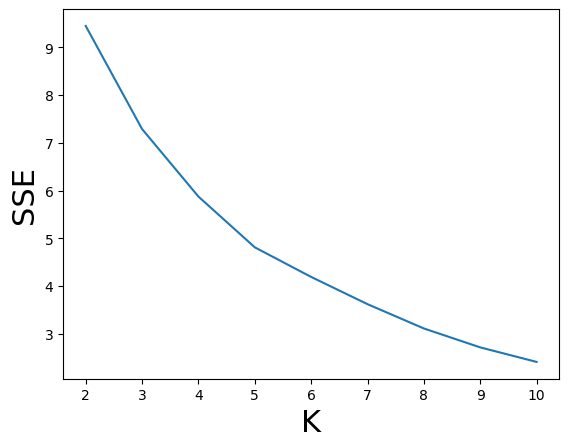

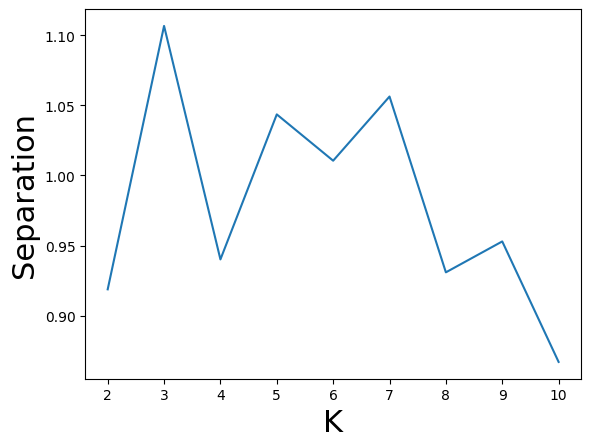

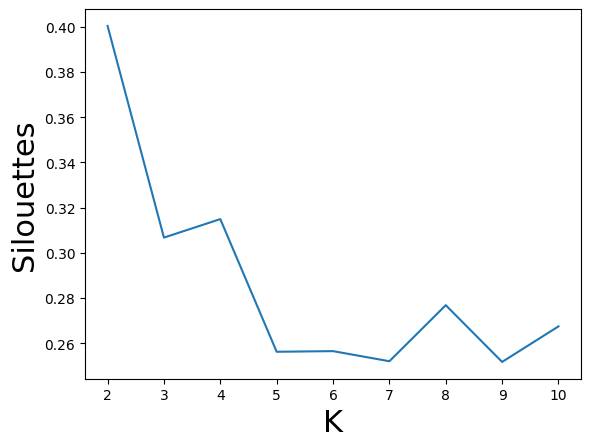

SSE : 4.811441206394376
Separation : 1.0434987175251085
Silhouette : 0.25618763686571944


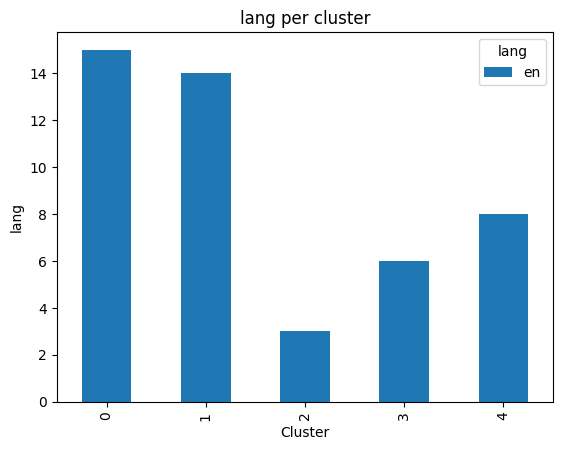

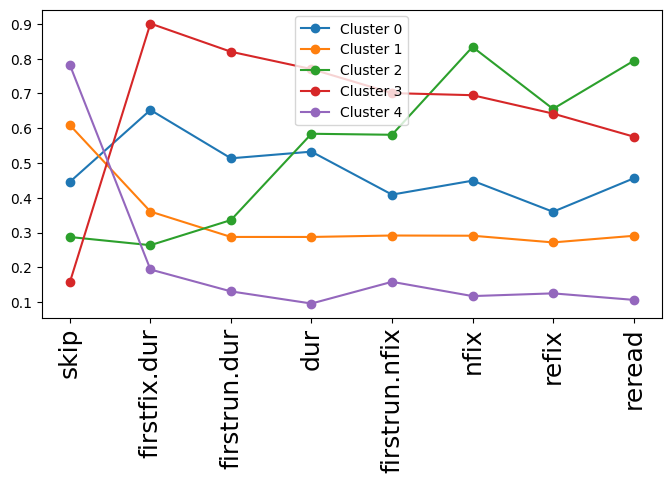

In [31]:
medoids_en = clusterize_user_profiling(reader_grouped_df_en, gaze_features)

In [32]:
medoids_en

['en_57', 'en_49', 'en_6', 'en_98', 'en_83']

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  8.29it/s]


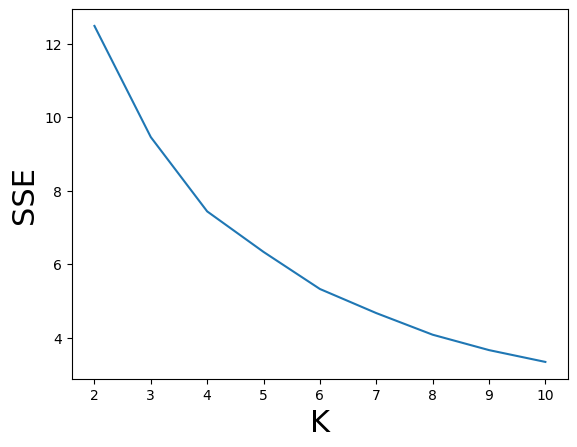

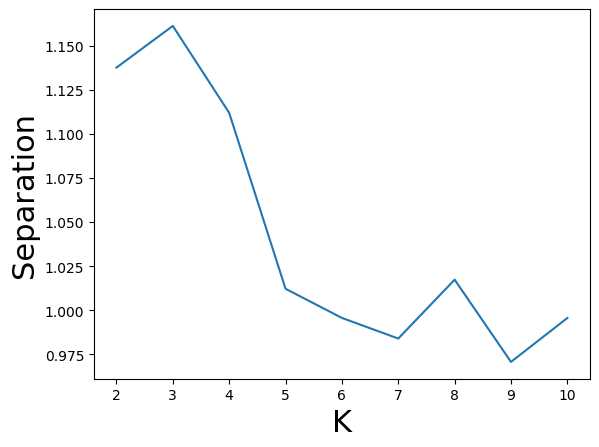

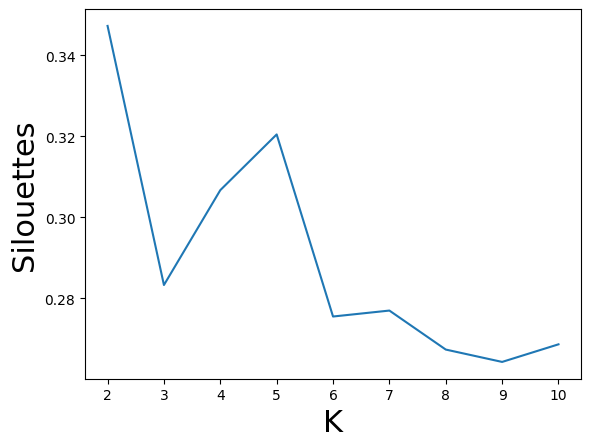

SSE : 6.330852926422977
Separation : 1.012203919286388
Silhouette : 0.32049591684305634


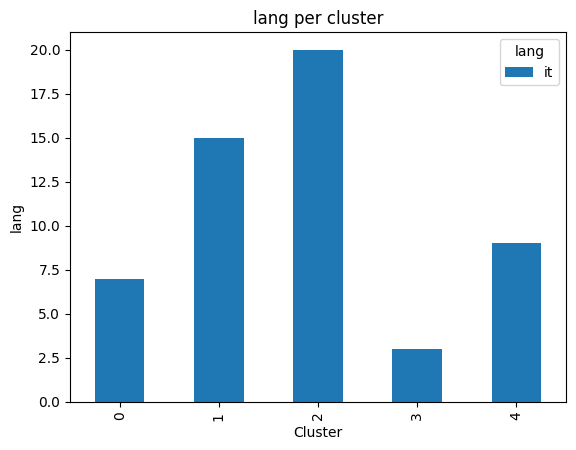

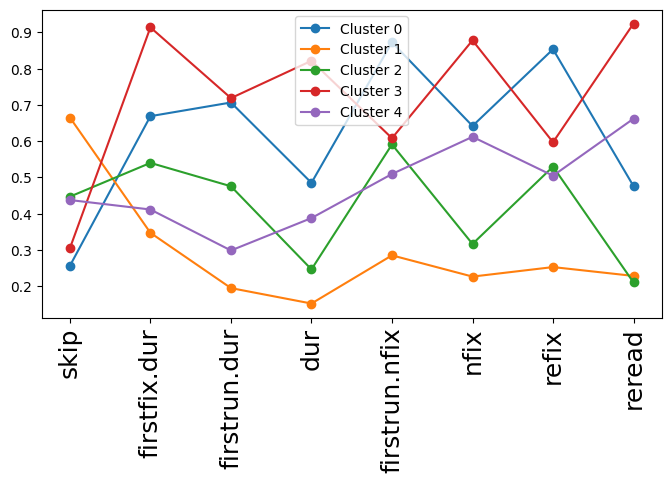

In [33]:
medoids_it = clusterize_user_profiling(reader_grouped_df_it, gaze_features)

In [34]:
medoids_it

['it_1', 'it_43', 'it_26', 'it_38', 'it_44']

### Creating one dataset per medoid, so one for each representative user

In [35]:
datasets_en = []

for user in medoids_en:
    datasets_en.append(df_en[df_en.uniform_id == user].reset_index(drop=True))
    
datasets_it = []

for user in medoids_it:
    datasets_it.append(df_it[df_it.uniform_id == user].reset_index(drop=True))

In [36]:
for df in datasets_en:
    print(df[["skip", "firstrun.dur", "dur", "firstrun.nfix", "nfix", "refix", "reread"]].corr())

                   skip  firstrun.dur       dur  firstrun.nfix      nfix  \
skip           1.000000     -0.675569 -0.560567      -0.727102 -0.566734   
firstrun.dur  -0.675569      1.000000  0.781809       0.893922  0.684457   
dur           -0.560567      0.781809  1.000000       0.742987  0.951989   
firstrun.nfix -0.727102      0.893922  0.742987       1.000000  0.762120   
nfix          -0.566734      0.684457  0.951989       0.762120  1.000000   
refix         -0.306229      0.563566  0.582094       0.643150  0.624592   
reread        -0.391131      0.320888  0.635811       0.359912  0.661109   

                  refix    reread  
skip          -0.306229 -0.391131  
firstrun.dur   0.563566  0.320888  
dur            0.582094  0.635811  
firstrun.nfix  0.643150  0.359912  
nfix           0.624592  0.661109  
refix          1.000000  0.325424  
reread         0.325424  1.000000  
                   skip  firstrun.dur       dur  firstrun.nfix      nfix  \
skip           1.000000    

In [37]:
for df in datasets_it:
    print(df[["skip", "firstrun.dur", "dur", "firstrun.nfix", "nfix", "refix", "reread"]].corr())

                   skip  firstrun.dur       dur  firstrun.nfix      nfix  \
skip           1.000000     -0.583761 -0.514952      -0.659623 -0.540887   
firstrun.dur  -0.583761      1.000000  0.711491       0.887289  0.617442   
dur           -0.514952      0.711491  1.000000       0.664771  0.948555   
firstrun.nfix -0.659623      0.887289  0.664771       1.000000  0.693626   
nfix          -0.540887      0.617442  0.948555       0.693626  1.000000   
refix         -0.345916      0.587841  0.587481       0.682763  0.632666   
reread        -0.380702      0.206793  0.615508       0.231311  0.650295   

                  refix    reread  
skip          -0.345916 -0.380702  
firstrun.dur   0.587841  0.206793  
dur            0.587481  0.615508  
firstrun.nfix  0.682763  0.231311  
nfix           0.632666  0.650295  
refix          1.000000  0.271309  
reread         0.271309  1.000000  
                   skip  firstrun.dur       dur  firstrun.nfix      nfix  \
skip           1.000000    

In [38]:
for i, df in enumerate(datasets_en):
    print(f"Len dataset_{i} : {df.shape}")

Len dataset_0 : (1222, 14)
Len dataset_1 : (1041, 14)
Len dataset_2 : (2107, 14)
Len dataset_3 : (2107, 14)
Len dataset_4 : (2107, 14)


In [39]:
for i, df in enumerate(datasets_it):
    print(f"Len dataset_{i} : {df.shape}")

Len dataset_0 : (1932, 14)
Len dataset_1 : (1402, 14)
Len dataset_2 : (2113, 14)
Len dataset_3 : (1577, 14)
Len dataset_4 : (1592, 14)


### Saving datasets

In [40]:
for user, df in zip(medoids_en, datasets_en):
    df.to_csv(f"augmenting_nlms_meco_data/en/{user}_dataset.csv")

In [41]:
for user, df in zip(medoids_it, datasets_it):
    df.to_csv(f"augmenting_nlms_meco_data/it/{user}_dataset.csv")